In [2]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import re
import string

In [4]:
# Load dataset
df_fake = pd.read_csv("../input/fake-news-detection/Fake.csv")
df_true = pd.read_csv("../input/fake-news-detection/True.csv")

In [5]:
# Log first 5 data to ensure files loaded
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
#define class
df_fake["class"] = 0
df_true["class"] = 1

In [7]:
df_fake.shape, df_true.shape

((23481, 5), (21417, 5))

In [8]:
# Combine datasets
df = pd.concat([df_true, df_fake], axis=0)

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head()

,title,text,subject,date,class
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0


In [9]:
# Dataset shape
print("Dataset shape:", df.shape)

# Class distribution
df["class"].value_counts()

Dataset shape: (44898, 5)


class
0    23481
1    21417
Name: count, dtype: int64

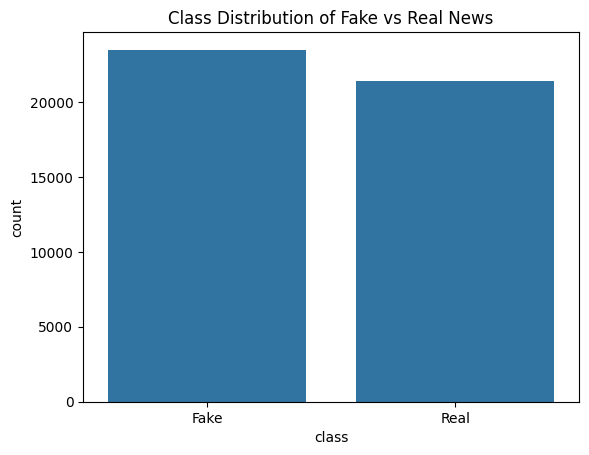

In [10]:
# Filter the dataset along with show class distribution
sns.countplot(x="class", data=df)# Missing values
df.isnull().sum()

# Duplicate rows
df.duplicated().sum()
plt.xticks([0, 1], ["Fake", "Real"])
plt.title("Class Distribution of Fake vs Real News")
plt.show()


In [11]:
# Missing values
df.isnull().sum()

# Duplicate rows
df.duplicated().sum()

np.int64(209)

In [12]:
# Remove rows with any null values
df = df.dropna()

print("Dataset shape after removing null values:", df.shape)

Dataset shape after removing null values: (44898, 5)


In [13]:
# Remove duplicate rows
df = df.drop_duplicates()

print("Dataset shape after removing duplicates:", df.shape)

Dataset shape after removing duplicates: (44689, 5)


In [14]:
# Verify cleaning
print("Null values:\n", df.isnull().sum())
print("Duplicate rows:", df.duplicated().sum())
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

Null values:
 title      0
text       0
subject    0
date       0
class      0
dtype: int64
Duplicate rows: 0


In [15]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [16]:
# Text pre processing
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

In [17]:
df["clean_text"] = df["text"].apply(clean_text)
df[["text", "clean_text"]].head()

,text,clean_text
0,BEIRUT (Reuters) - Top Lebanese Druze politici...,beirut reuters top lebanese druze politician ...
1,TOKYO (Reuters) - A court in Japan on Friday o...,tokyo reuters a court in japan on friday orde...
2,The Washington Post reported: The patriarchs o...,the washington post reported the patriarchs of...
3,ABC host George Stephanopoulos sat down with K...,abc host george stephanopoulos sat down with k...
4,WASHINGTON (Reuters) - The Democratic leaders ...,washington reuters the democratic leaders of ...


In [18]:
# Train test split
X = df["clean_text"]
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 35751
Testing samples: 8938


In [19]:
#Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF Train Shape:", X_train_tfidf.shape)
print("TF-IDF Test Shape:", X_test_tfidf.shape)

TF-IDF Train Shape: (35751, 5000)
TF-IDF Test Shape: (8938, 5000)


In [20]:
#train/fit the module
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [21]:
# Log accuracy
y_pred_rf = rf_model.predict(X_test_tfidf)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_rf, target_names=["Fake", "Real"]))

Random Forest Accuracy: 0.996979189975386

Classification Report:

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4696
        Real       1.00      1.00      1.00      4242

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



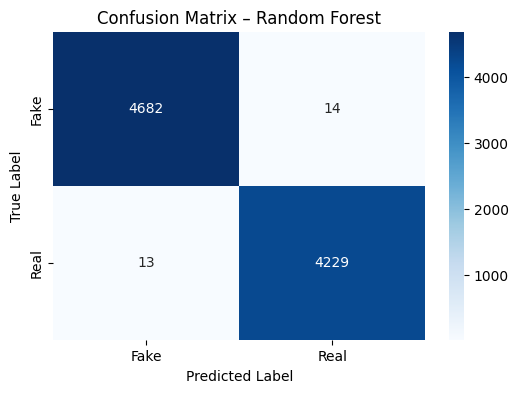

In [22]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Fake", "Real"],
            yticklabels=["Fake", "Real"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – Random Forest")
plt.show()

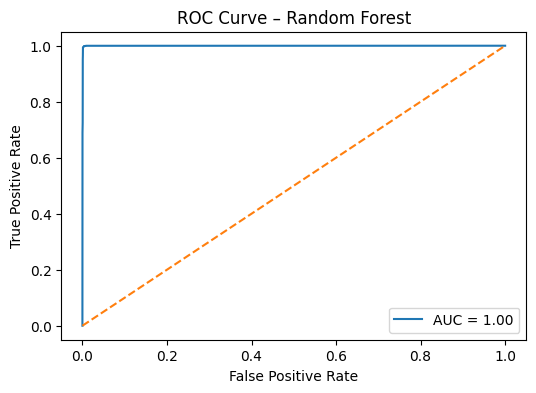

In [23]:
# ROC curve
from sklearn.metrics import roc_curve, auc

y_probs_rf = rf_model.predict_proba(X_test_tfidf)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_probs_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest")
plt.legend()
plt.show()

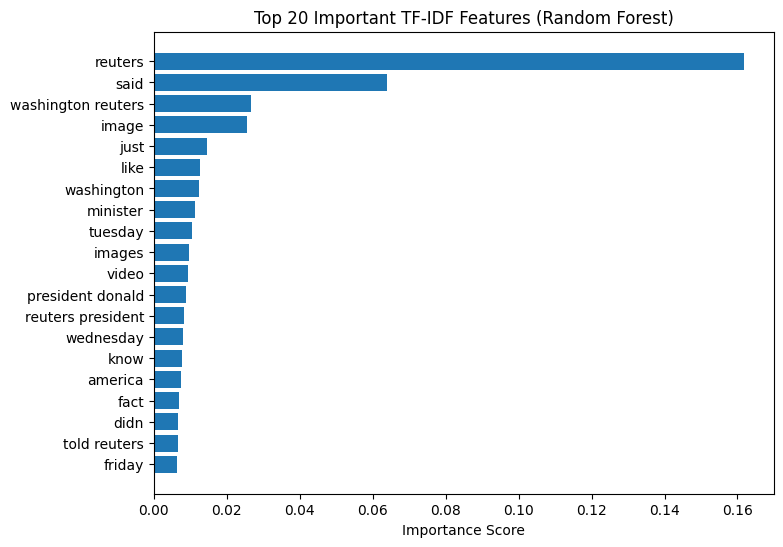

In [24]:
# Barchart for important features
feature_names = tfidf.get_feature_names_out()
importances = rf_model.feature_importances_

indices = np.argsort(importances)[-20:]

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title("Top 20 Important TF-IDF Features (Random Forest)")
plt.xlabel("Importance Score")
plt.show()

In [25]:
# Sample data
sample_df = pd.DataFrame({
    "Text": X_test.sample(5, random_state=42),
    "True Label": y_test.sample(5, random_state=42),
})

sample_df["Predicted Label"] = rf_model.predict(
    tfidf.transform(sample_df["Text"])
)

sample_df

,Text,True Label,Predicted Label
1762,this is scary this guy was our secretary of st...,0,0
3615,moscow reuters a draft law allowing moscow to...,1,1
26679,share this hillarious video everywhere,0,0
20092,almost every wellknown celebrity will likely g...,0,0
24136,this house republican didn t see this humiliat...,0,0


In [42]:
#Imports 
import torch
from torch.utils.data import Dataset, DataLoader

from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)

from torch.optim import AdamW

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [27]:
#Use GPU if available
#Note: It trains extreamly slow on just cpu so better to use GPU or TPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [28]:
bert_text = df["text"].astype(str).tolist()
bert_labels = df["class"].tolist()

In [29]:
#Train test split
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    bert_text,
    bert_labels,
    test_size=0.2,
    stratify=bert_labels,
    random_state=42
)

In [30]:
#Tokenize
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [31]:
#encoding - Convert text to number
train_encodings = tokenizer(
    X_train_bert,
    truncation=True,
    padding=True,
    max_length=256
)

test_encodings = tokenizer(
    X_test_bert,
    truncation=True,
    padding=True,
    max_length=256
)

In [32]:
#Classification
class FakeNewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

In [33]:
#load the encoding
train_dataset = FakeNewsDataset(train_encodings, y_train_bert)
test_dataset = FakeNewsDataset(test_encodings, y_test_bert)

In [34]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [35]:
# Pre trained BERT module
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)
#Store it in device to reduce cpu usage-use GPU
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [36]:
#Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 2 #2 iteration
total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [43]:
#Train the module as per above instructions
#Note: This is time consuming as it need to train entire module - took me ~1.5 hr with CPU+GPU
model.train()

for epoch in range(epochs):
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.4f}")

KeyboardInterrupt: 

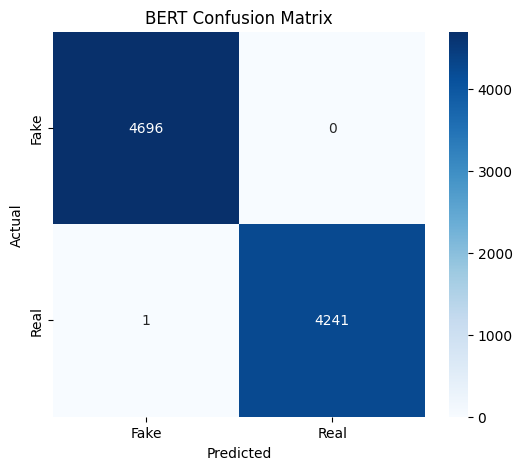

              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00      4696
        Real       1.00      1.00      1.00      4242

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938

Accuracy: 0.9999
Precision: 1.0000
Recall: 0.9998
F1-Score: 0.9999


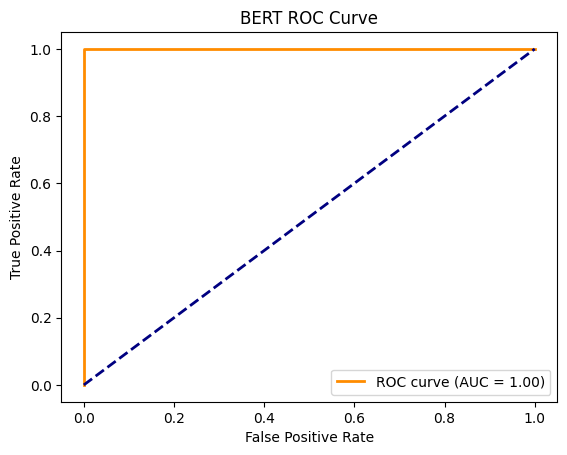

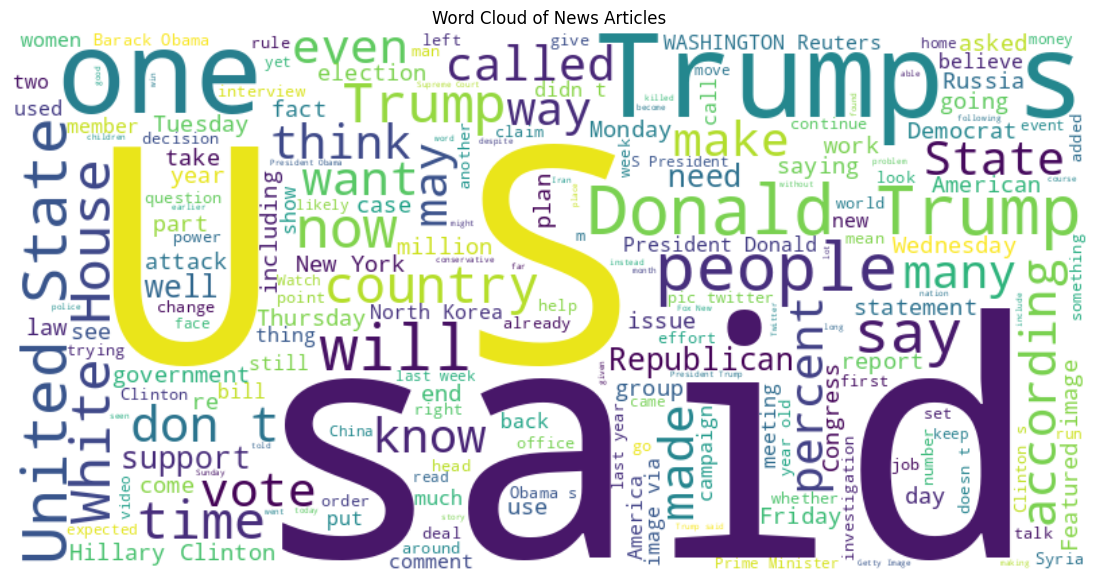

In [40]:
#Model evaluation with diagrams
from torch.nn.functional import softmax
from wordcloud import WordCloud
import numpy as np

# Ensure model is in evaluation mode
model.eval()
predictions = []
true_labels = []
probs = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # Class prediction
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        # Probability for ROC
        prob = softmax(outputs.logits, dim=1)[:,1]  # Probability for "Real" class
        probs.extend(prob.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('BERT Confusion Matrix')
plt.show()

# Classification Metrics
print(classification_report(true_labels, predictions, target_names=['Fake', 'Real']))

accuracy = np.mean(np.array(predictions) == np.array(true_labels))
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BERT ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Word Cloud (for visualizing important words in dataset)
text = " ".join(df['text'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of News Articles")
plt.show()